In [1]:
# importing libraries
import torch
import torch.nn as nn
import torch.nn.functional as ff
import torch.optim as optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
plt.style.use('dark_background')

def dataloader():
    """
    Returns dictionaries with torch tensors
    """
    train = MNIST("files/", download = True, transform = ToTensor())
    test = MNIST("files/", download = True, transform = ToTensor(), train = False)
    train_dict = {i:train.data[train.targets == i].data/255 for i in range(10)}
    test_dict = {i:test.data[test.targets == i].data/255 for i in range(10)}

    return train_dict, test_dict

train, test = dataloader()

/home/cmaspi/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


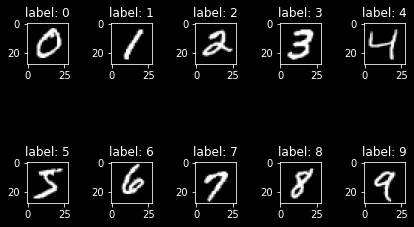

In [2]:
fig, ax = plt.subplots(2,5)
fig.tight_layout()
for i in range(2):
    for j in range(5):
        ax[i][j].imshow(train[5*i+j][0].numpy(), cmap = 'gray')
        ax[i][j].set_title(f'label: {5*i+j}')

In [3]:
# taking 100 samples for each class for training
x_train = torch.cat([train[i][:100] for i in range(10)]).reshape(1000,1,28,28)
y_train = torch.div(torch.arange(1000, dtype=torch.int),100,rounding_mode='trunc').type(torch.LongTensor)

# taking 10 samples from each class for testing
x_test = torch.cat([test[i][:10] for i in range(10)]).reshape(100,1,28,28)
y_test = torch.div(torch.arange(100, dtype=torch.int),10,rounding_mode='trunc').type(torch.LongTensor)

In [4]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5,padding = 2)
        self.conv1_ = nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Conv2d(4,4,5,padding = 2)
        self.conv2_ = nn.Sequential(nn.ReLU(), 
                                    nn.MaxPool2d(2,2)) 
        self.mlp1 = nn.Sequential(nn.Linear( 196, 49), 
                                    nn.ReLU())
        self.mlp2 = nn.Linear(49, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = x.view(-1, 196)
        x = self.mlp1(x)
        x = self.mlp2(x)
        return x
    
    def viz(self, x):
        ret = []
        x = self.conv1(x)
        ret.append(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        ret.append(x)
        return ret


In [5]:
loss_func = nn.CrossEntropyLoss()

In [6]:
def shuffle(train: torch.tensor, labels: torch.tensor):
        """
        Shuffles the data in a random permutation
        """
        n = train.shape[0]
        permutation = torch.randperm(n)
        train = train[permutation]
        labels = labels[permutation]
        return train, labels

def iterate_minibatches(train : torch.tensor, labels: torch.tensor, batch_size : int, shuffle_ : bool = True):
        """
        Gives minibatches
        """
        if shuffle_:
            train, labels = shuffle(train, labels)
        for start_idx in range(0, train.shape[0] + 1 - batch_size, batch_size):
            excerpt = slice(start_idx, start_idx+batch_size)
            yield train[excerpt], labels[excerpt]


In [7]:
def predict_logits(network, samples):
    network.eval()
    pred = network.forward(samples)
    return pred

def predict(network, samples):
    pred = predict_logits(network, samples)
    pred = ff.softmax(pred, -1)
    return pred

def accuracy(predicted, ground_truth):
    predicted = torch.argmax(predicted, axis = -1)
    return torch.mean((predicted == ground_truth).to(float))

def train(network, train, ground_truth, epochs, batch_size, optimizer):
    for epoch in range(epochs):
        for x,y in iterate_minibatches(train, ground_truth, batch_size):
            optimizer.zero_grad()
            pred = network.forward(x)
            batch_loss = loss_func(pred, y)
            batch_loss.backward()
            optimizer.step()    
        pred_train = predict_logits(network, x_train)
        pred_test = predict_logits(network, x_test)    
        print(f'Epoch #{epoch+1}')
        print(f'training loss {loss_func(pred_train, y_train)}')
        print(f'testing loss {loss_func(pred_test, y_test)}')
        print(f'training accuracy {accuracy(pred_train, y_train)}')
        print(f'testing accuracy {accuracy(pred_test, y_test)}')
        # Displaying activation maps
        single_image = x_train[0].reshape(1,1,28,28)
        layer_activation = network.viz(single_image)
        fig,ax = plt.subplots(2,4, figsize=(12,3))
        ax[0][0].imshow(layer_activation[0][:,0,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][1].imshow(layer_activation[0][:,1,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][2].imshow(layer_activation[0][:,2,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[0][3].imshow(layer_activation[0][:,3,:,:].detach().numpy().reshape(28,28), cmap = 'gray')
        ax[1][0].imshow(layer_activation[1][:,0,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][1].imshow(layer_activation[1][:,1,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][2].imshow(layer_activation[1][:,2,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        ax[1][3].imshow(layer_activation[1][:,3,:,:].detach().numpy().reshape(14,14), cmap = 'gray')
        plt.show()
        if epoch in [0,14]:
            logits = predict(network, x_test)
            X_embedded = TSNE(n_components=2, learning_rate='auto', init='random',perplexity=10, n_iter = 10000).fit_transform(logits.detach().numpy())
            fig, ax = plt.subplots()
            for i in range(10):
                ax.scatter(X_embedded[10*i:10*i+10, 0], X_embedded[10*i:10*i+10, 1], label=f'{y_test[10*i]}')
            ax.legend()
            plt.show()
        
        


# SGD with batch size = 15, learning rate = 0.01 (The model doesn't converge, it does converge if the learning rate is 0.1)

Epoch #1
training loss 2.303039073944092
testing loss 2.3043313026428223
training accuracy 0.1
testing accuracy 0.1


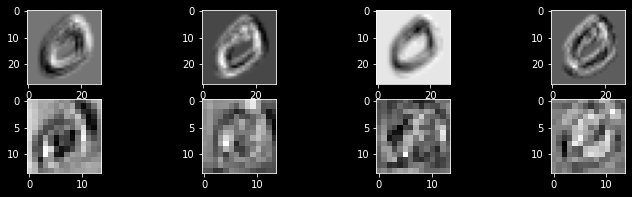

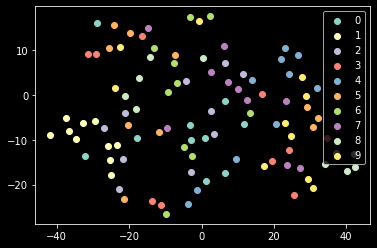

Epoch #2
training loss 2.3027095794677734
testing loss 2.303999423980713
training accuracy 0.1
testing accuracy 0.1


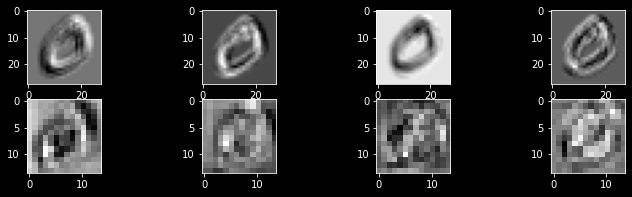

Epoch #3
training loss 2.3023574352264404
testing loss 2.3036465644836426
training accuracy 0.1
testing accuracy 0.1


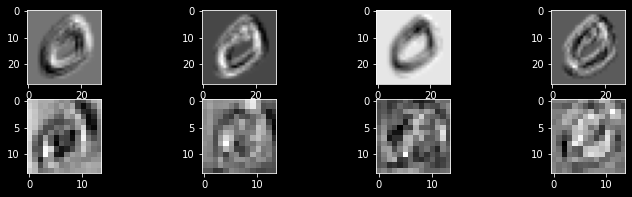

Epoch #4
training loss 2.302009105682373
testing loss 2.3032963275909424
training accuracy 0.1
testing accuracy 0.1


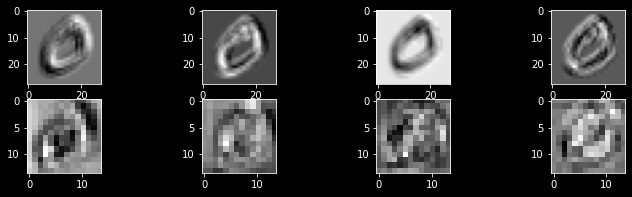

Epoch #5
training loss 2.3016464710235596
testing loss 2.3029274940490723
training accuracy 0.1
testing accuracy 0.1


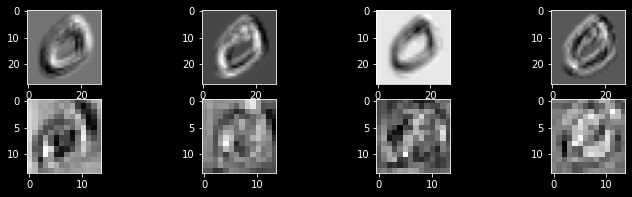

Epoch #6
training loss 2.301283836364746
testing loss 2.3025550842285156
training accuracy 0.1
testing accuracy 0.1


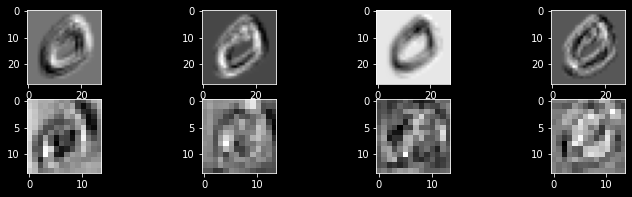

Epoch #7
training loss 2.300920009613037
testing loss 2.3021905422210693
training accuracy 0.1
testing accuracy 0.1


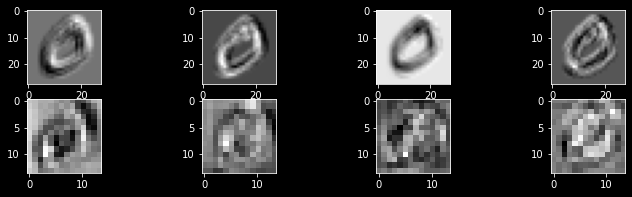

Epoch #8
training loss 2.300558090209961
testing loss 2.301837682723999
training accuracy 0.1
testing accuracy 0.1


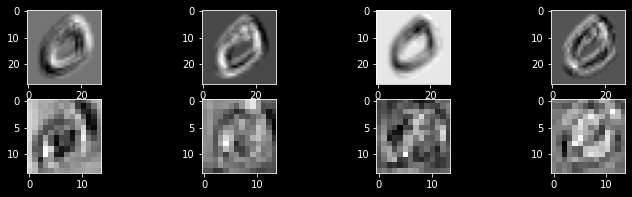

Epoch #9
training loss 2.3002052307128906
testing loss 2.3014955520629883
training accuracy 0.1
testing accuracy 0.1


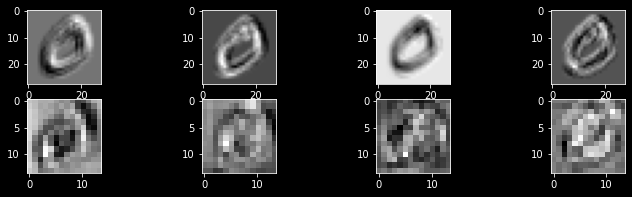

Epoch #10
training loss 2.2998733520507812
testing loss 2.301177740097046
training accuracy 0.1
testing accuracy 0.1


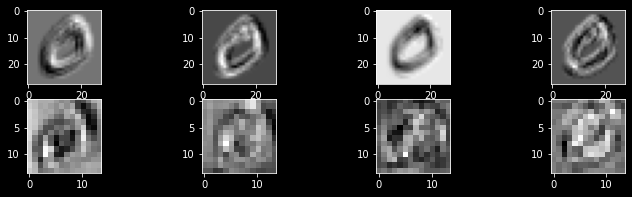

Epoch #11
training loss 2.299549102783203
testing loss 2.3008623123168945
training accuracy 0.1
testing accuracy 0.1


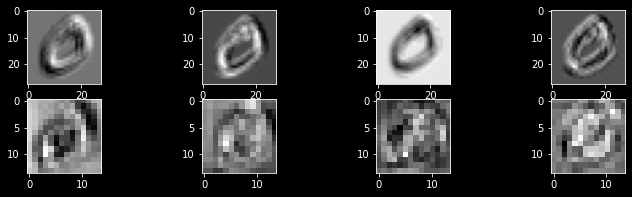

Epoch #12
training loss 2.2992212772369385
testing loss 2.3005483150482178
training accuracy 0.1
testing accuracy 0.1


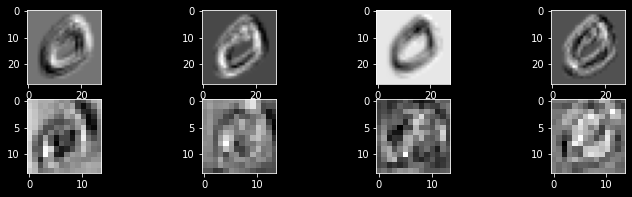

Epoch #13
training loss 2.2989089488983154
testing loss 2.30025053024292
training accuracy 0.1
testing accuracy 0.1


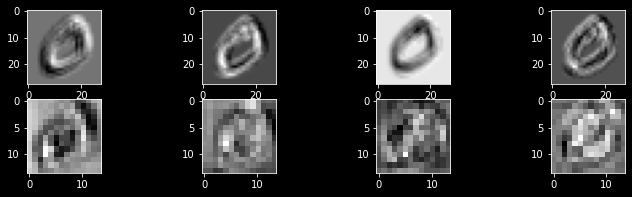

Epoch #14
training loss 2.2985968589782715
testing loss 2.299960136413574
training accuracy 0.1
testing accuracy 0.1


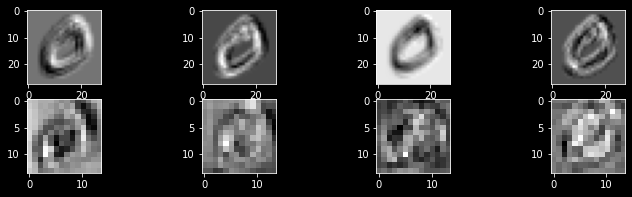

Epoch #15
training loss 2.298288583755493
testing loss 2.299665927886963
training accuracy 0.1
testing accuracy 0.1


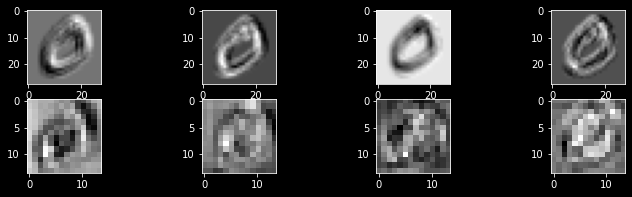

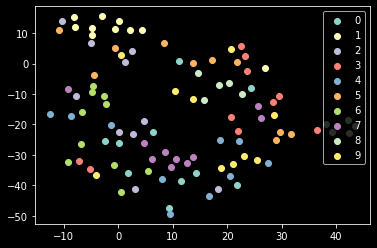

In [8]:
network = Network()
optimizer_SGD = optim.SGD(network.parameters(), lr=0.001)
train(network, x_train, y_train, 15, 15, optimizer_SGD)

# Momentum, batch size = 15

Epoch #1
training loss 2.3001537322998047
testing loss 2.298525333404541
training accuracy 0.1
testing accuracy 0.1


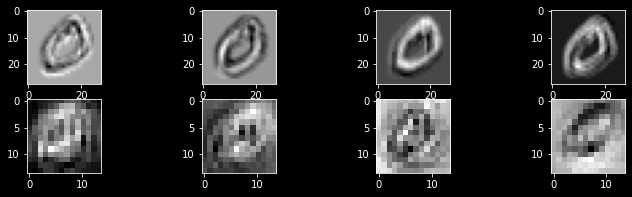

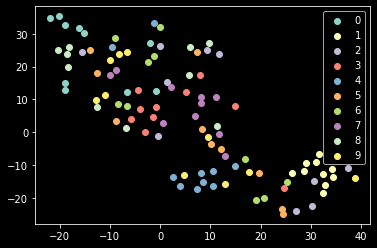

Epoch #2
training loss 2.2960808277130127
testing loss 2.2946317195892334
training accuracy 0.108
testing accuracy 0.12


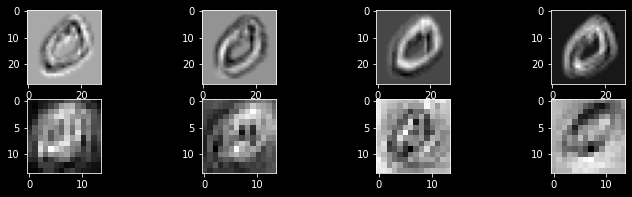

Epoch #3
training loss 2.2905850410461426
testing loss 2.289217472076416
training accuracy 0.156
testing accuracy 0.16


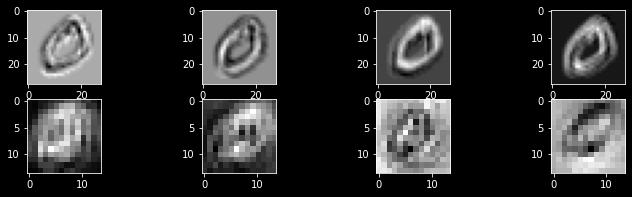

Epoch #4
training loss 2.2819063663482666
testing loss 2.280461072921753
training accuracy 0.186
testing accuracy 0.21


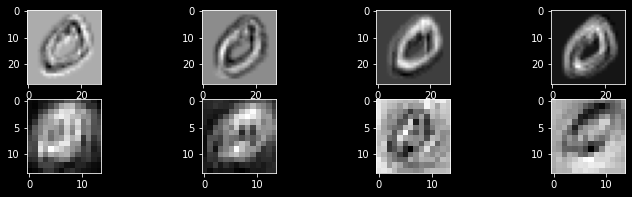

Epoch #5
training loss 2.268040180206299
testing loss 2.2661852836608887
training accuracy 0.189
testing accuracy 0.19


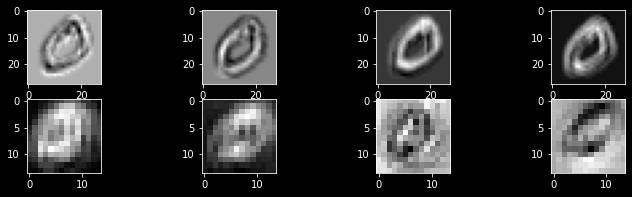

Epoch #6
training loss 2.2422847747802734
testing loss 2.2422122955322266
training accuracy 0.246
testing accuracy 0.28


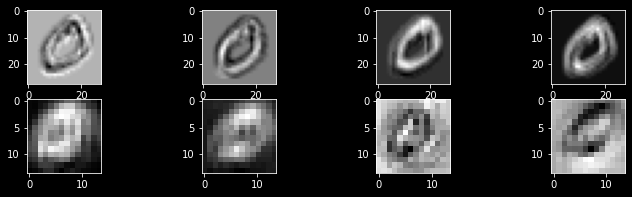

Epoch #7
training loss 2.18280291557312
testing loss 2.186227560043335
training accuracy 0.285
testing accuracy 0.28


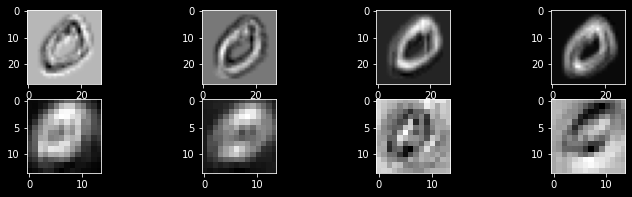

Epoch #8
training loss 2.019649028778076
testing loss 2.0378329753875732
training accuracy 0.512
testing accuracy 0.48


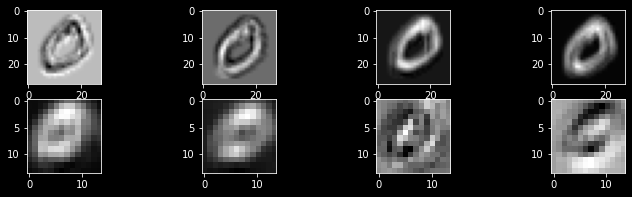

Epoch #9
training loss 1.541921854019165
testing loss 1.597465991973877
training accuracy 0.603
testing accuracy 0.58


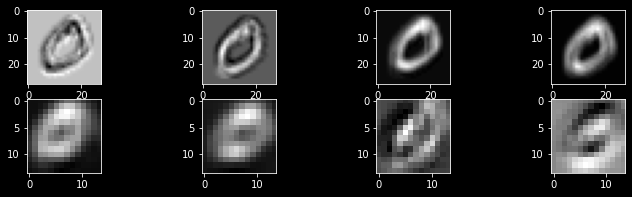

Epoch #10
training loss 1.0463426113128662
testing loss 1.1124464273452759
training accuracy 0.686
testing accuracy 0.65


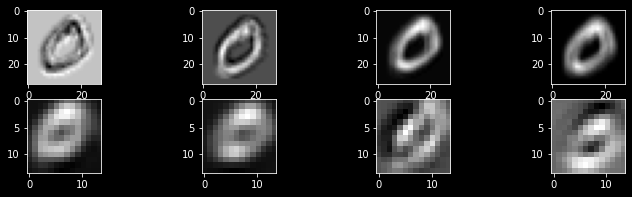

Epoch #11
training loss 0.8621767163276672
testing loss 0.8936769962310791
training accuracy 0.729
testing accuracy 0.78


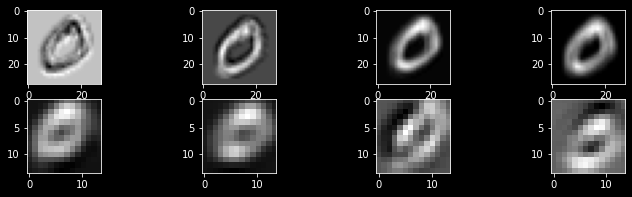

Epoch #12
training loss 0.7040935158729553
testing loss 0.7223750352859497
training accuracy 0.785
testing accuracy 0.75


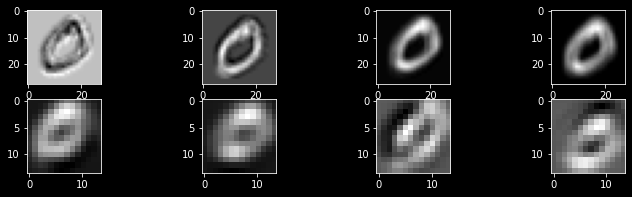

Epoch #13
training loss 0.5996078848838806
testing loss 0.5939692854881287
training accuracy 0.831
testing accuracy 0.85


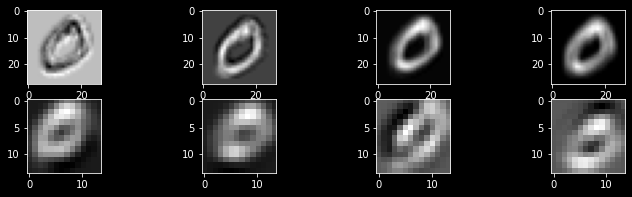

Epoch #14
training loss 0.5694249272346497
testing loss 0.581432580947876
training accuracy 0.827
testing accuracy 0.83


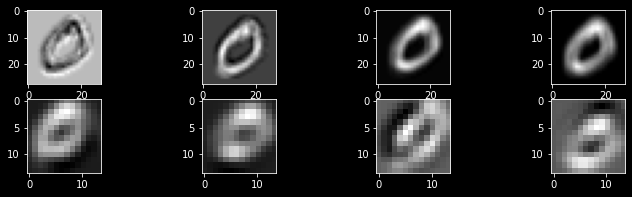

Epoch #15
training loss 0.5998187065124512
testing loss 0.6164515614509583
training accuracy 0.801
testing accuracy 0.78


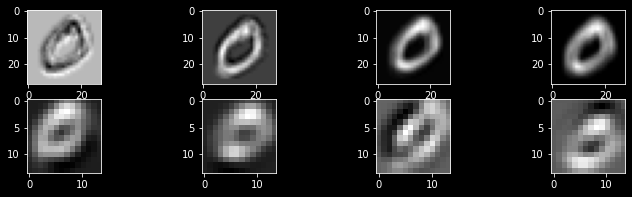

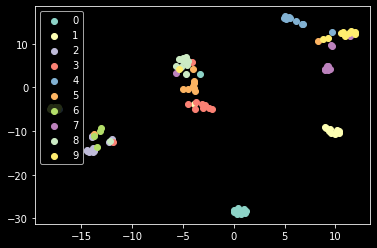

In [9]:
network = Network()
optimizer_momentum = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
train(network, x_train, y_train, 15, 15, optimizer_momentum)

# RMS prop, batch size = 15

Epoch #1
training loss 1.164045810699463
testing loss 1.2250820398330688
training accuracy 0.662
testing accuracy 0.67


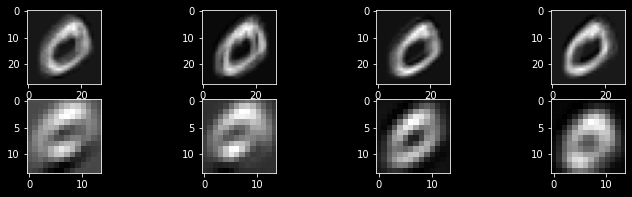

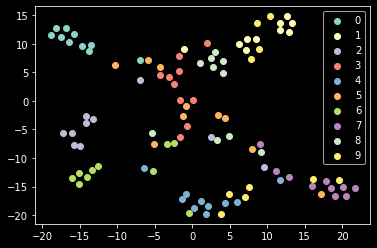

Epoch #2
training loss 0.7207033038139343
testing loss 0.7721840739250183
training accuracy 0.784
testing accuracy 0.78


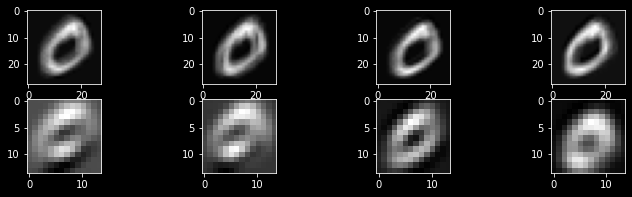

Epoch #3
training loss 0.546782910823822
testing loss 0.5846851468086243
training accuracy 0.834
testing accuracy 0.83


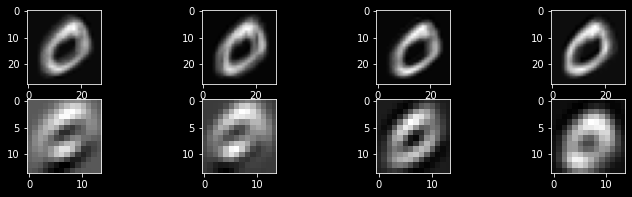

Epoch #4
training loss 0.5366429090499878
testing loss 0.6172276139259338
training accuracy 0.836
testing accuracy 0.78


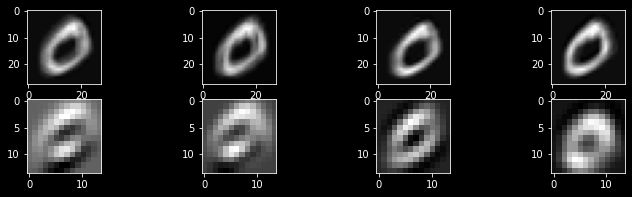

Epoch #5
training loss 0.416856050491333
testing loss 0.43428173661231995
training accuracy 0.879
testing accuracy 0.85


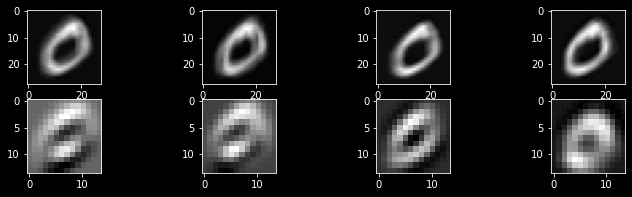

Epoch #6
training loss 0.47596049308776855
testing loss 0.504957377910614
training accuracy 0.846
testing accuracy 0.83


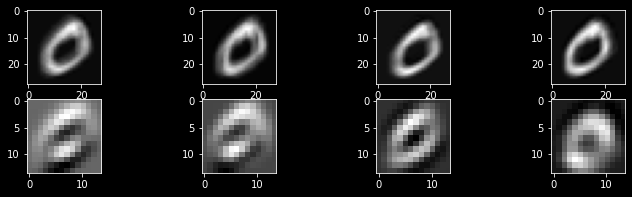

Epoch #7
training loss 0.33536574244499207
testing loss 0.333146333694458
training accuracy 0.898
testing accuracy 0.9


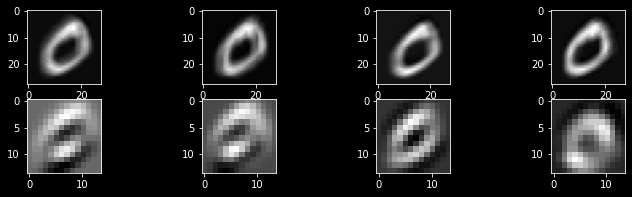

Epoch #8
training loss 0.2744728922843933
testing loss 0.27077290415763855
training accuracy 0.921
testing accuracy 0.95


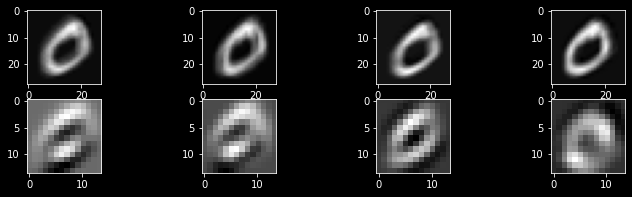

Epoch #9
training loss 0.24513491988182068
testing loss 0.25192496180534363
training accuracy 0.938
testing accuracy 0.94


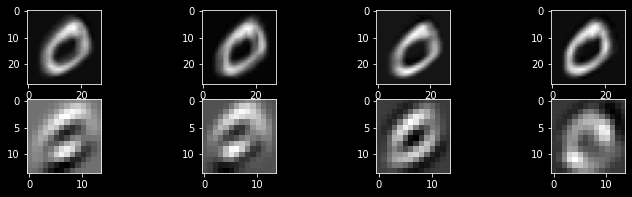

Epoch #10
training loss 0.21683856844902039
testing loss 0.220869243144989
training accuracy 0.942
testing accuracy 0.93


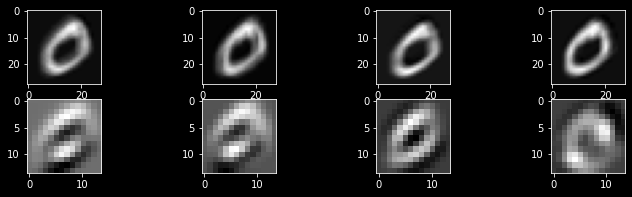

Epoch #11
training loss 0.2566997706890106
testing loss 0.2981022596359253
training accuracy 0.92
testing accuracy 0.91


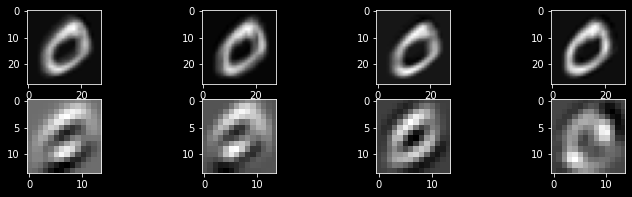

Epoch #12
training loss 0.18172624707221985
testing loss 0.2050238996744156
training accuracy 0.95
testing accuracy 0.95


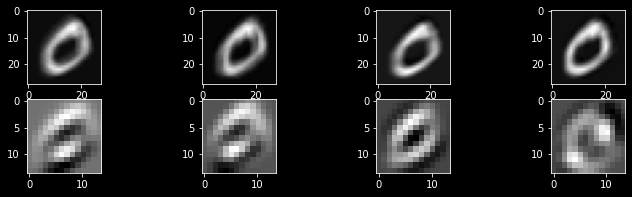

Epoch #13
training loss 0.15633593499660492
testing loss 0.18608108162879944
training accuracy 0.959
testing accuracy 0.91


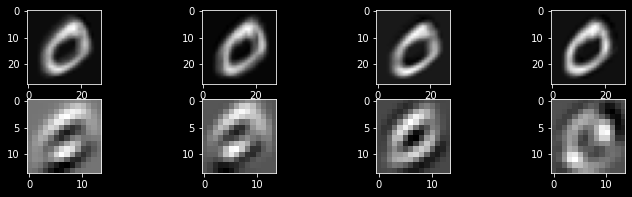

Epoch #14
training loss 0.16045472025871277
testing loss 0.1669735163450241
training accuracy 0.947
testing accuracy 0.95


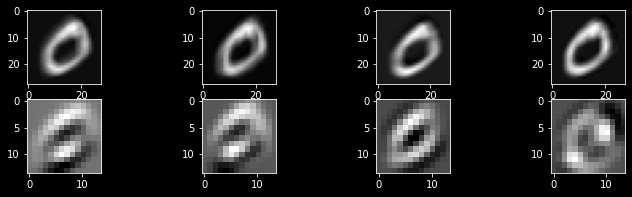

Epoch #15
training loss 0.14007152616977692
testing loss 0.16013070940971375
training accuracy 0.962
testing accuracy 0.93


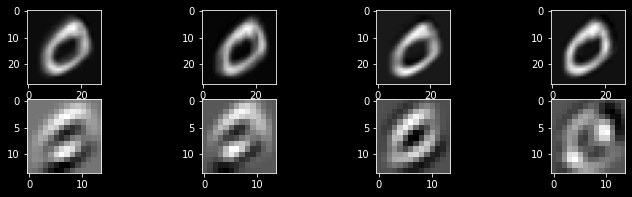

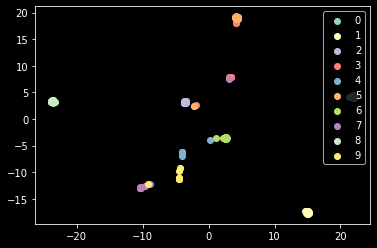

In [10]:
network = Network()
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

# SGD with batch size = 50, learning rate = 0.01 (The model doesn't converge, it does converge if the learning rate is 0.1)

Epoch #1
training loss 2.30655837059021
testing loss 2.306994915008545
training accuracy 0.09
testing accuracy 0.1


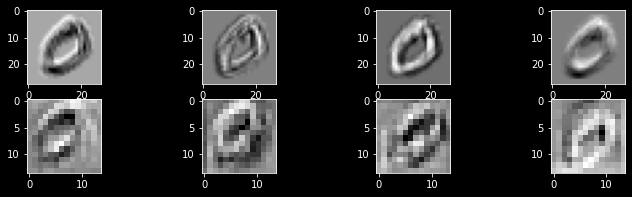

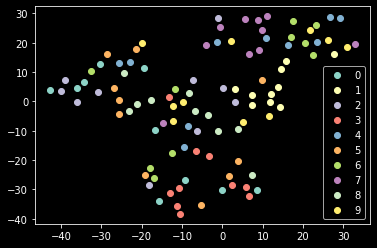

Epoch #2
training loss 2.306475877761841
testing loss 2.3069183826446533
training accuracy 0.09
testing accuracy 0.1


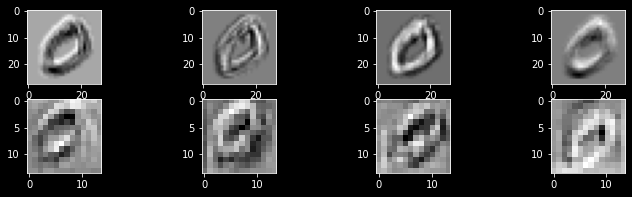

Epoch #3
training loss 2.3063948154449463
testing loss 2.3068435192108154
training accuracy 0.09
testing accuracy 0.1


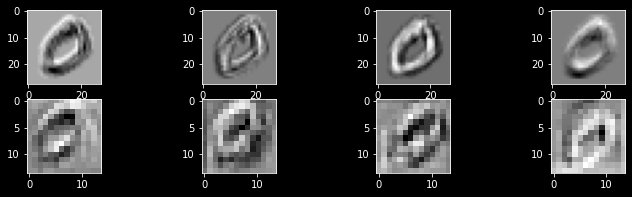

Epoch #4
training loss 2.3063149452209473
testing loss 2.306769371032715
training accuracy 0.09
testing accuracy 0.1


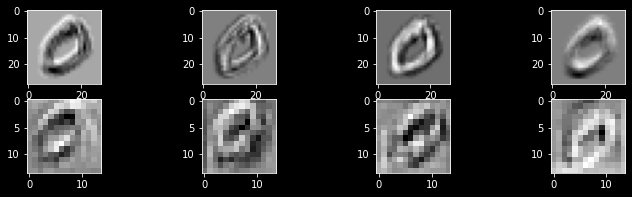

Epoch #5
training loss 2.306236743927002
testing loss 2.306697130203247
training accuracy 0.09
testing accuracy 0.1


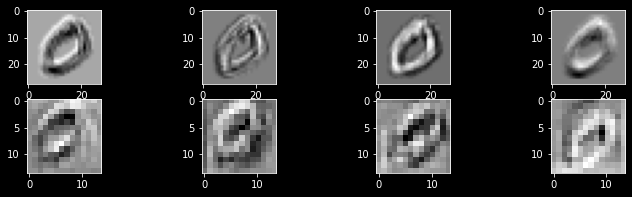

Epoch #6
training loss 2.3061604499816895
testing loss 2.3066251277923584
training accuracy 0.092
testing accuracy 0.1


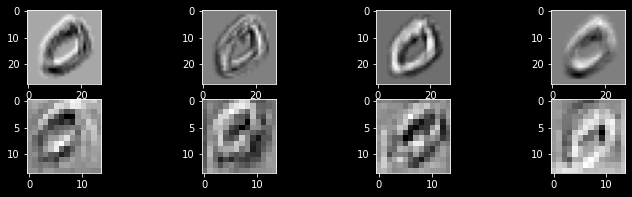

Epoch #7
training loss 2.306084394454956
testing loss 2.3065543174743652
training accuracy 0.093
testing accuracy 0.1


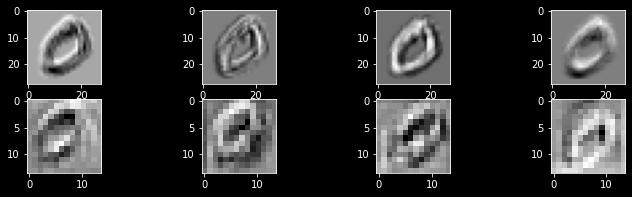

Epoch #8
training loss 2.3060097694396973
testing loss 2.3064818382263184
training accuracy 0.094
testing accuracy 0.1


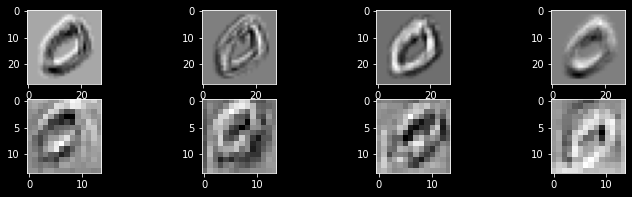

Epoch #9
training loss 2.305936098098755
testing loss 2.306410312652588
training accuracy 0.094
testing accuracy 0.1


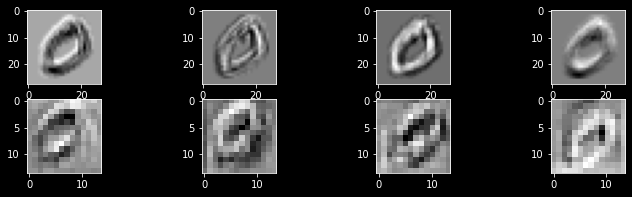

Epoch #10
training loss 2.305863618850708
testing loss 2.3063390254974365
training accuracy 0.094
testing accuracy 0.09


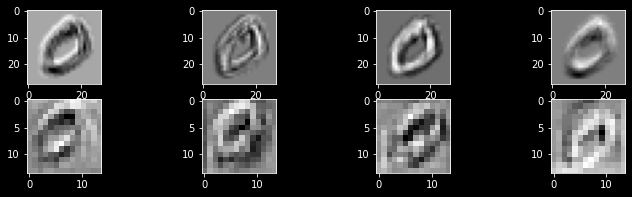

Epoch #11
training loss 2.3057925701141357
testing loss 2.3062682151794434
training accuracy 0.094
testing accuracy 0.09


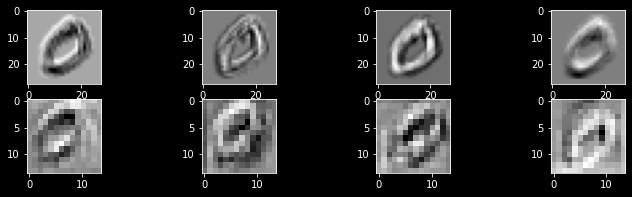

Epoch #12
training loss 2.3057241439819336
testing loss 2.306199550628662
training accuracy 0.094
testing accuracy 0.09


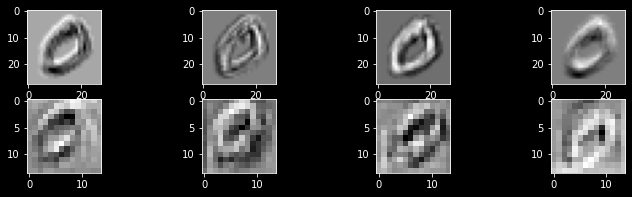

Epoch #13
training loss 2.3056561946868896
testing loss 2.306131362915039
training accuracy 0.095
testing accuracy 0.09


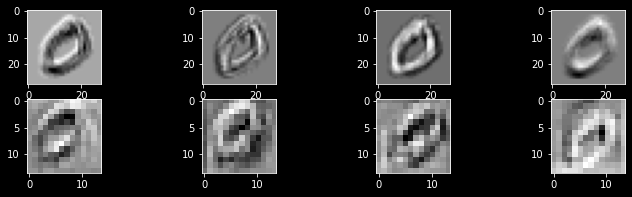

Epoch #14
training loss 2.3055896759033203
testing loss 2.306063652038574
training accuracy 0.095
testing accuracy 0.09


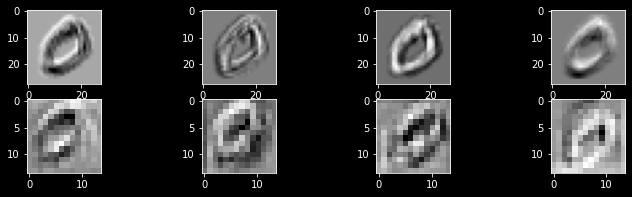

Epoch #15
training loss 2.3055241107940674
testing loss 2.3059964179992676
training accuracy 0.095
testing accuracy 0.09


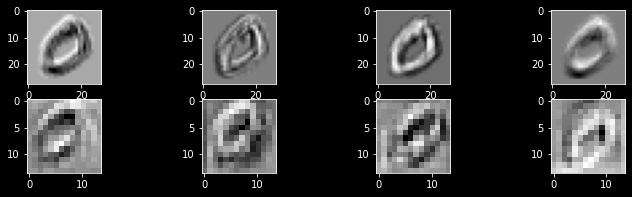

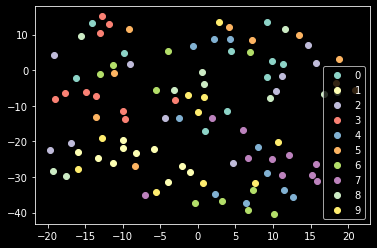

In [11]:
network = Network()
optimizer_SGD = optim.SGD(network.parameters(), lr=0.001)
train(network, x_train, y_train, 15, 50, optimizer_SGD)

# Momentum, batch size = 50

Epoch #1
training loss 2.3035764694213867
testing loss 2.305813789367676
training accuracy 0.099
testing accuracy 0.1


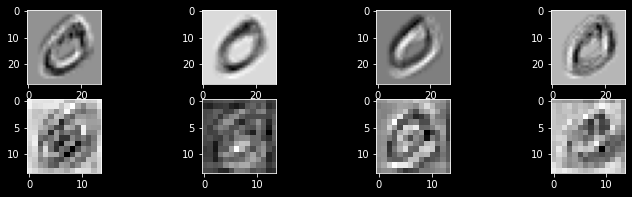

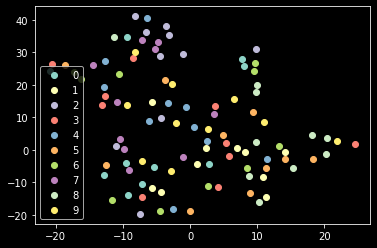

Epoch #2
training loss 2.303130865097046
testing loss 2.305405378341675
training accuracy 0.099
testing accuracy 0.1


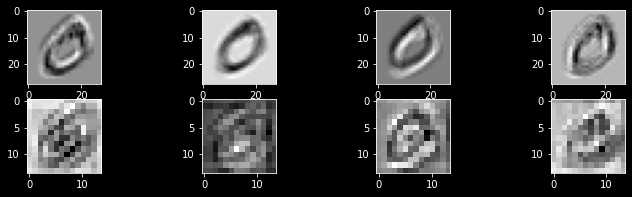

Epoch #3
training loss 2.302687883377075
testing loss 2.304997444152832
training accuracy 0.099
testing accuracy 0.1


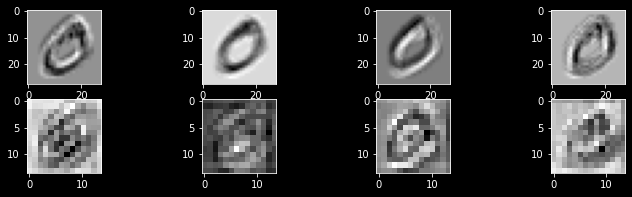

Epoch #4
training loss 2.302232503890991
testing loss 2.3045928478240967
training accuracy 0.098
testing accuracy 0.1


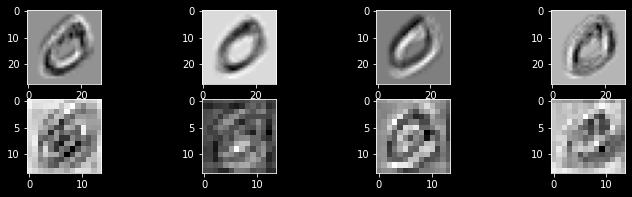

Epoch #5
training loss 2.30179500579834
testing loss 2.3042054176330566
training accuracy 0.101
testing accuracy 0.1


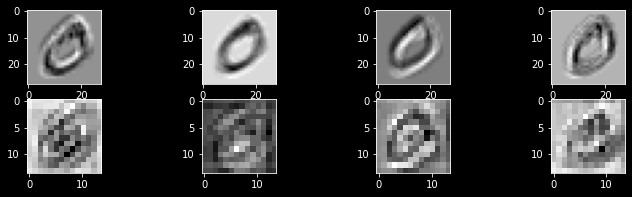

Epoch #6
training loss 2.301378011703491
testing loss 2.3038530349731445
training accuracy 0.1
testing accuracy 0.1


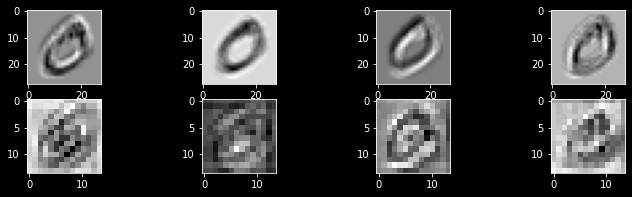

Epoch #7
training loss 2.300933361053467
testing loss 2.3034470081329346
training accuracy 0.101
testing accuracy 0.1


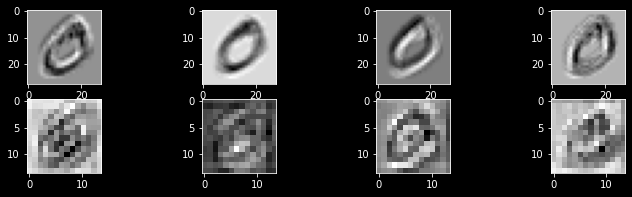

Epoch #8
training loss 2.3005118370056152
testing loss 2.3030877113342285
training accuracy 0.103
testing accuracy 0.1


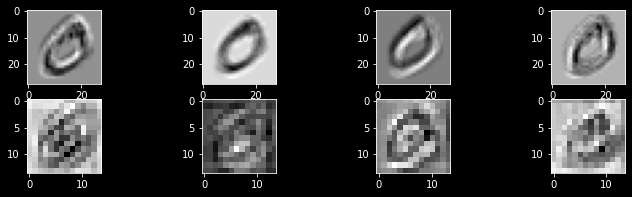

Epoch #9
training loss 2.3000552654266357
testing loss 2.3026621341705322
training accuracy 0.104
testing accuracy 0.1


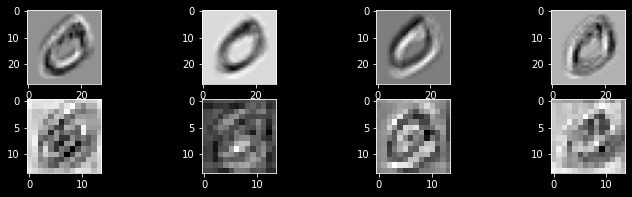

Epoch #10
training loss 2.299600839614868
testing loss 2.3022234439849854
training accuracy 0.106
testing accuracy 0.1


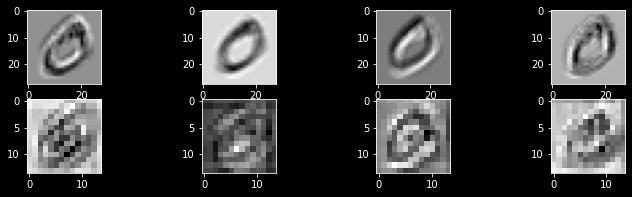

Epoch #11
training loss 2.2991445064544678
testing loss 2.30180287361145
training accuracy 0.104
testing accuracy 0.1


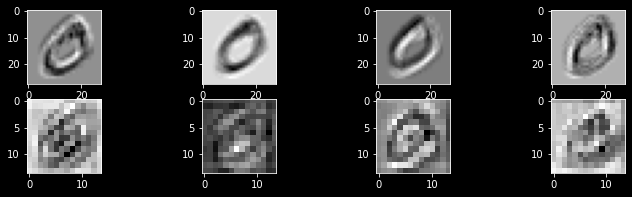

Epoch #12
training loss 2.2986767292022705
testing loss 2.3013694286346436
training accuracy 0.108
testing accuracy 0.11


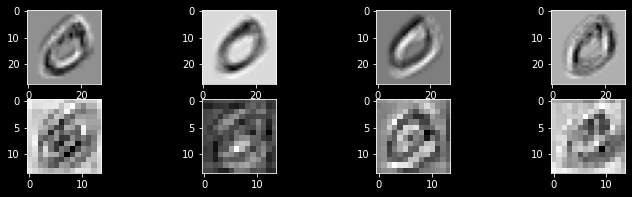

Epoch #13
training loss 2.298224925994873
testing loss 2.3009729385375977
training accuracy 0.108
testing accuracy 0.11


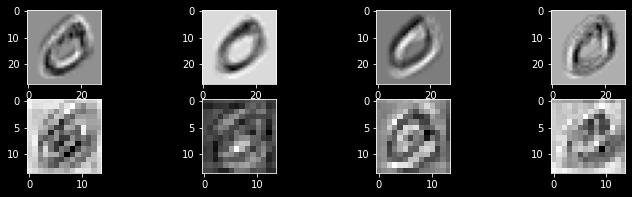

Epoch #14
training loss 2.297758102416992
testing loss 2.300546646118164
training accuracy 0.112
testing accuracy 0.12


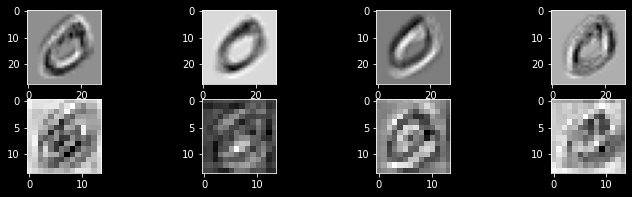

Epoch #15
training loss 2.2972817420959473
testing loss 2.300128698348999
training accuracy 0.117
testing accuracy 0.11


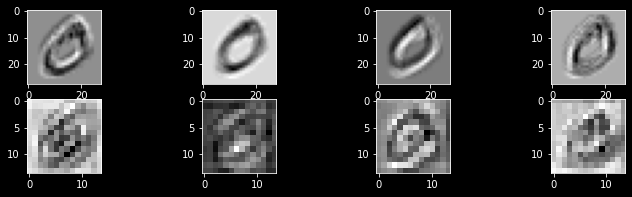

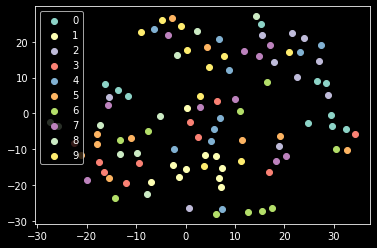

In [12]:
network = Network()
optimizer_momentum = optim.SGD(network.parameters(), lr=0.001, momentum=0.9)
train(network, x_train, y_train, 15, 50, optimizer_momentum)

# RMSprop, batch size = 50

Epoch #1
training loss 2.0201339721679688
testing loss 2.0336709022521973
training accuracy 0.518
testing accuracy 0.47


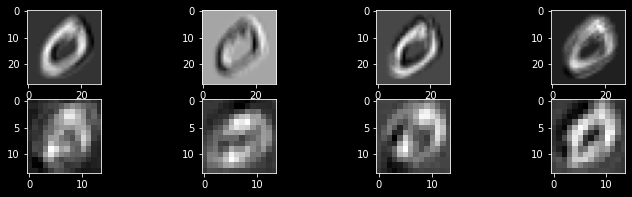

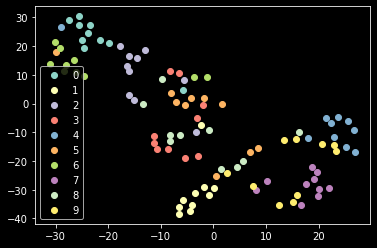

Epoch #2
training loss 1.3753676414489746
testing loss 1.4232285022735596
training accuracy 0.702
testing accuracy 0.63


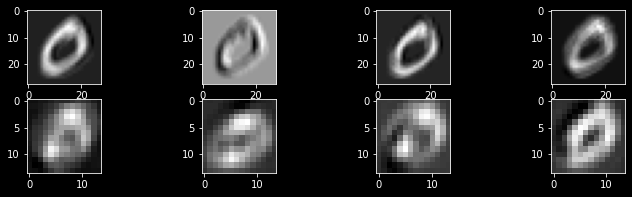

Epoch #3
training loss 1.009214162826538
testing loss 1.0618348121643066
training accuracy 0.689
testing accuracy 0.58


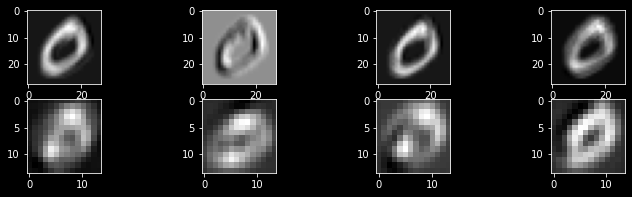

Epoch #4
training loss 0.753550112247467
testing loss 0.797832727432251
training accuracy 0.763
testing accuracy 0.72


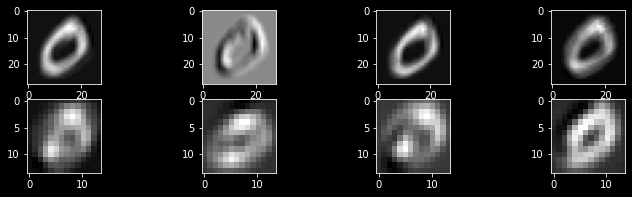

Epoch #5
training loss 0.6642578840255737
testing loss 0.7016503810882568
training accuracy 0.793
testing accuracy 0.77


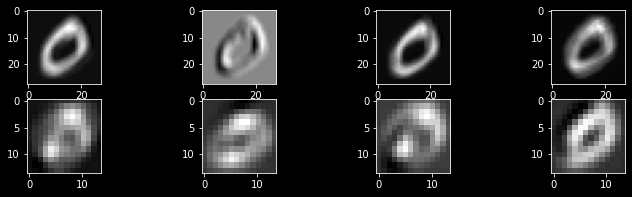

Epoch #6
training loss 0.6101307272911072
testing loss 0.6375188827514648
training accuracy 0.809
testing accuracy 0.74


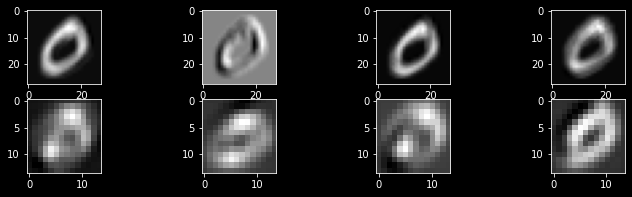

Epoch #7
training loss 0.5337138175964355
testing loss 0.556154191493988
training accuracy 0.839
testing accuracy 0.79


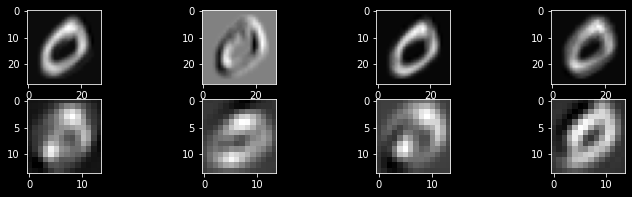

Epoch #8
training loss 0.4950719177722931
testing loss 0.5196952223777771
training accuracy 0.838
testing accuracy 0.81


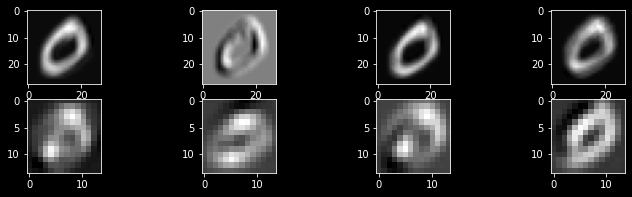

Epoch #9
training loss 0.4556676149368286
testing loss 0.4838148355484009
training accuracy 0.859
testing accuracy 0.82


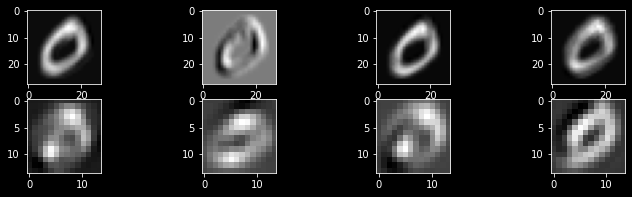

Epoch #10
training loss 0.45107364654541016
testing loss 0.480355829000473
training accuracy 0.857
testing accuracy 0.82


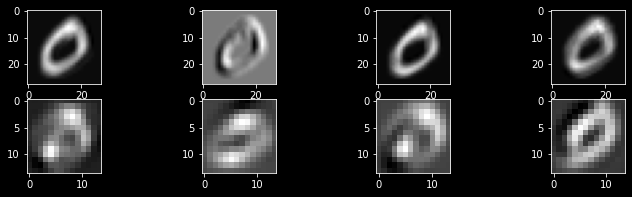

Epoch #11
training loss 0.40429890155792236
testing loss 0.4384404718875885
training accuracy 0.878
testing accuracy 0.84


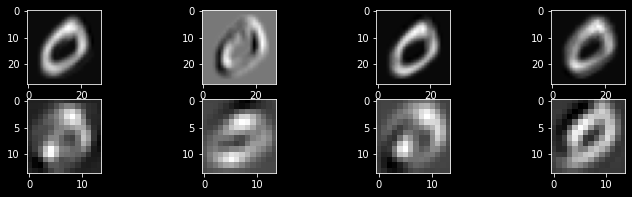

Epoch #12
training loss 0.39103731513023376
testing loss 0.3932022452354431
training accuracy 0.881
testing accuracy 0.89


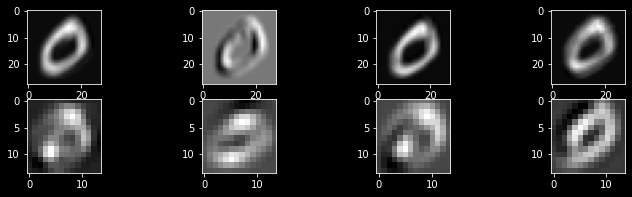

Epoch #13
training loss 0.3898506760597229
testing loss 0.3976324498653412
training accuracy 0.865
testing accuracy 0.85


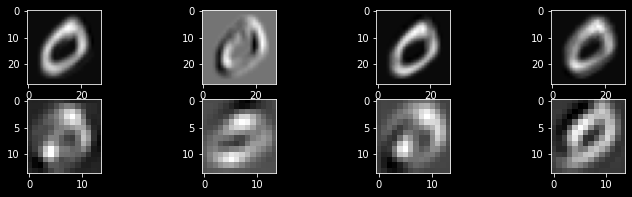

Epoch #14
training loss 0.3070146143436432
testing loss 0.31829407811164856
training accuracy 0.911
testing accuracy 0.9


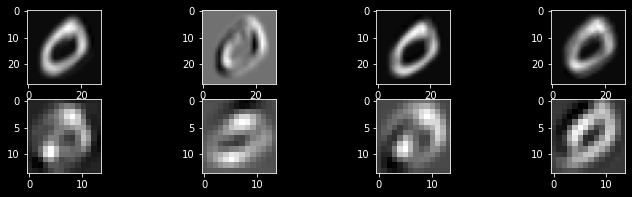

Epoch #15
training loss 0.30245837569236755
testing loss 0.3026005029678345
training accuracy 0.907
testing accuracy 0.88


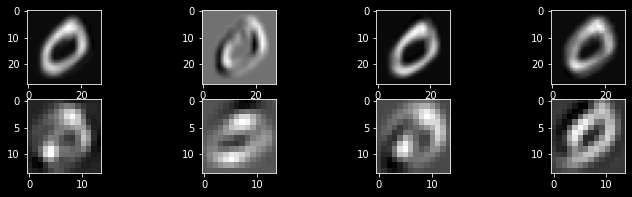

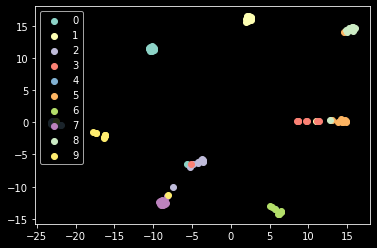

In [13]:
network = Network()
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 50, optimizer_rmsprop)

In [17]:
class Network_dropout(nn.Module):
    def __init__(self, p):
        self.p = p
        super(Network_dropout, self).__init__()
        self.conv1 = nn.Conv2d(1,4,5,padding = 2)
        self.conv1_ = nn.Sequential(nn.ReLU(),
                                    nn.MaxPool2d(2,2)) 
        self.conv2 = nn.Conv2d(4,4,5,padding = 2)
        self.conv2_ = nn.Sequential(nn.ReLU(), 
                                    nn.MaxPool2d(2,2)) 
        self.mlp1 = nn.Sequential(nn.Linear( 196, 49), 
                                    nn.ReLU(),
                                    nn.Dropout(p = self.p))                                                                            
        self.mlp2 = nn.Linear(49, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        x = self.conv2_(x)
        x = x.view(-1, 196)
        x = self.mlp1(x)
        x = self.mlp2(x)
        return x
    
    def viz(self, x):
        ret = []
        x = self.conv1(x)
        ret.append(x)
        x = self.conv1_(x)
        x = self.conv2(x)
        ret.append(x)
        return ret


Epoch #1
training loss 1.8339762687683105
testing loss 1.8395634889602661
training accuracy 0.434
testing accuracy 0.44


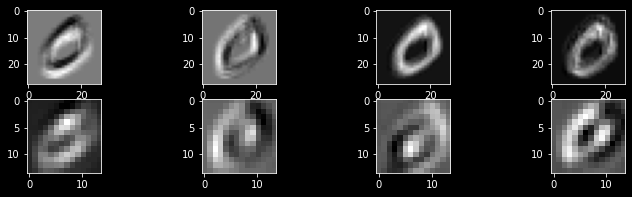

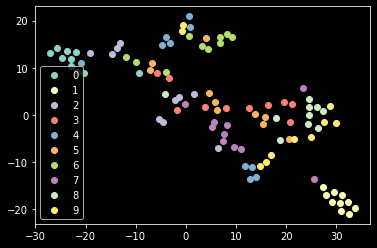

Epoch #2
training loss 0.8355166912078857
testing loss 0.8678297400474548
training accuracy 0.78
testing accuracy 0.76


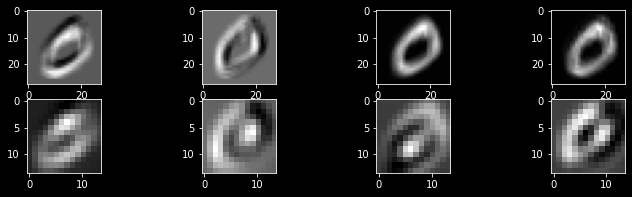

Epoch #3
training loss 0.5169330835342407
testing loss 0.5217956304550171
training accuracy 0.846
testing accuracy 0.87


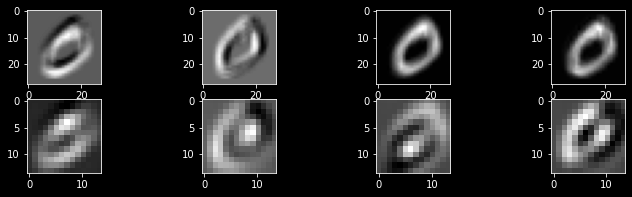

Epoch #4
training loss 0.45230329036712646
testing loss 0.4998255670070648
training accuracy 0.849
testing accuracy 0.8


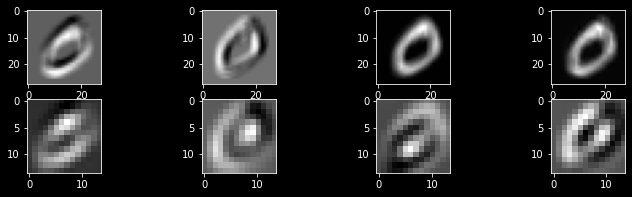

Epoch #5
training loss 0.3805612623691559
testing loss 0.3858201205730438
training accuracy 0.875
testing accuracy 0.85


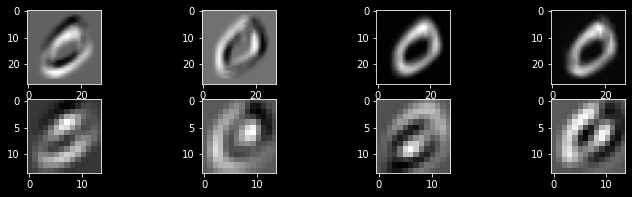

Epoch #6
training loss 0.2773974537849426
testing loss 0.287202924489975
training accuracy 0.916
testing accuracy 0.91


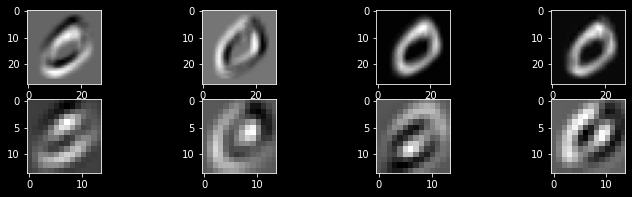

Epoch #7
training loss 0.24342484772205353
testing loss 0.22490769624710083
training accuracy 0.924
testing accuracy 0.94


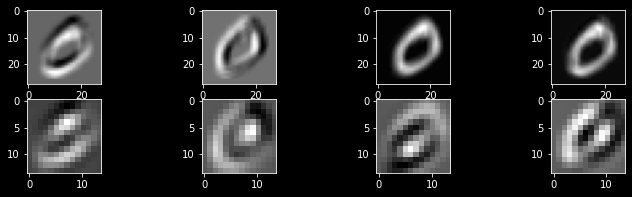

Epoch #8
training loss 0.2195528894662857
testing loss 0.2196551114320755
training accuracy 0.935
testing accuracy 0.92


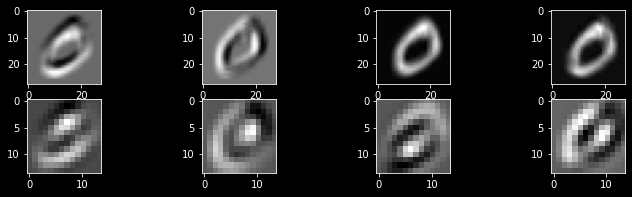

Epoch #9
training loss 0.2240910828113556
testing loss 0.2546178102493286
training accuracy 0.934
testing accuracy 0.92


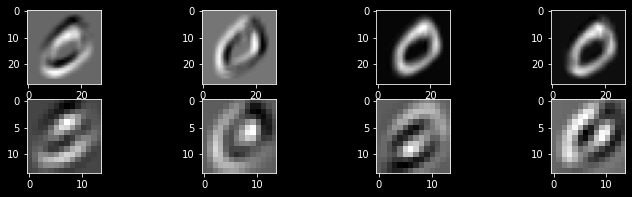

Epoch #10
training loss 0.16256476938724518
testing loss 0.1755553036928177
training accuracy 0.949
testing accuracy 0.93


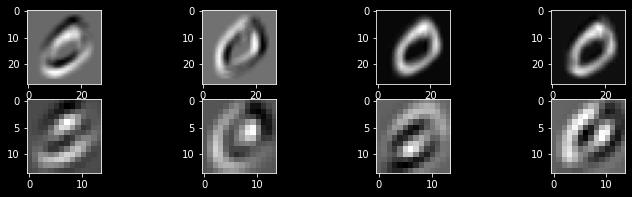

Epoch #11
training loss 0.1296941488981247
testing loss 0.14512251317501068
training accuracy 0.96
testing accuracy 0.95


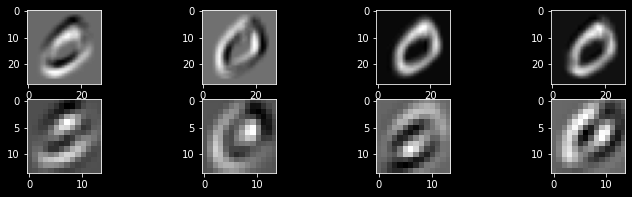

Epoch #12
training loss 0.13589218258857727
testing loss 0.1429743617773056
training accuracy 0.958
testing accuracy 0.96


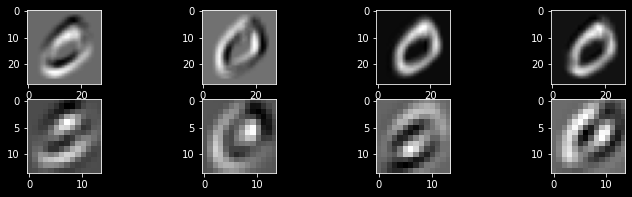

Epoch #13
training loss 0.127454474568367
testing loss 0.158342182636261
training accuracy 0.956
testing accuracy 0.96


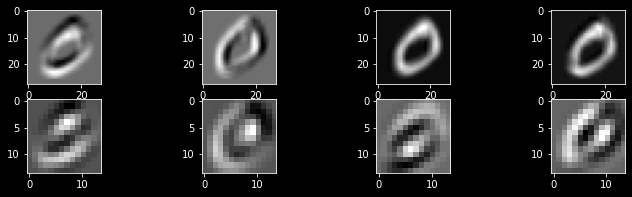

Epoch #14
training loss 0.09686149656772614
testing loss 0.1265844702720642
training accuracy 0.97
testing accuracy 0.95


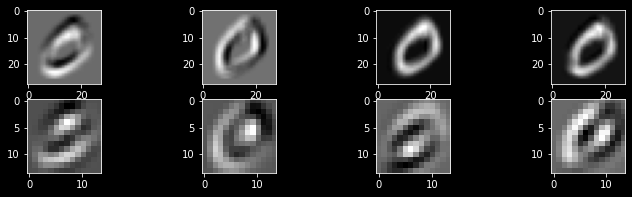

Epoch #15
training loss 0.08488203585147858
testing loss 0.12174379080533981
training accuracy 0.972
testing accuracy 0.95


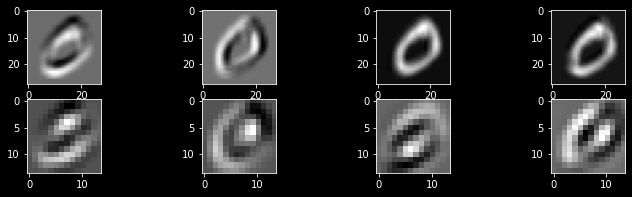

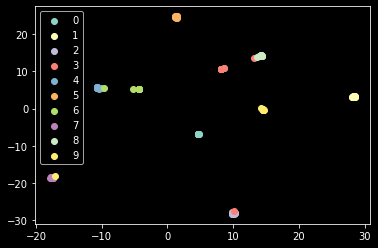

In [18]:
network = Network_dropout(0.2)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

Epoch #1
training loss 1.851203441619873
testing loss 1.8522261381149292
training accuracy 0.435
testing accuracy 0.44


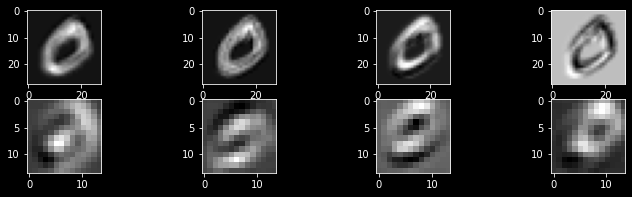

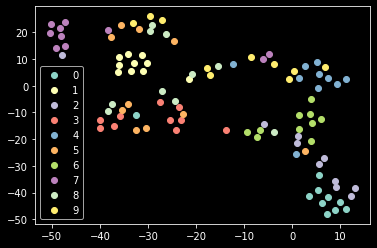

Epoch #2
training loss 0.9036754369735718
testing loss 0.9357709288597107
training accuracy 0.753
testing accuracy 0.74


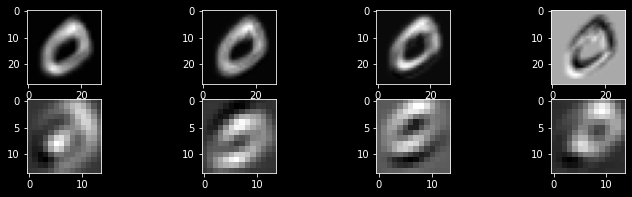

Epoch #3
training loss 0.5796209573745728
testing loss 0.5602102279663086
training accuracy 0.828
testing accuracy 0.83


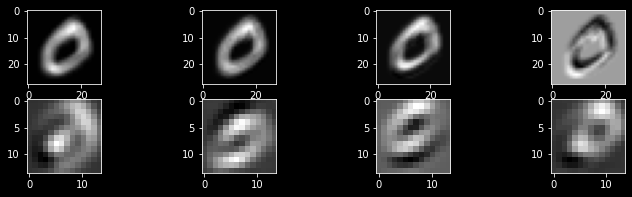

Epoch #4
training loss 0.47905421257019043
testing loss 0.47624558210372925
training accuracy 0.859
testing accuracy 0.86


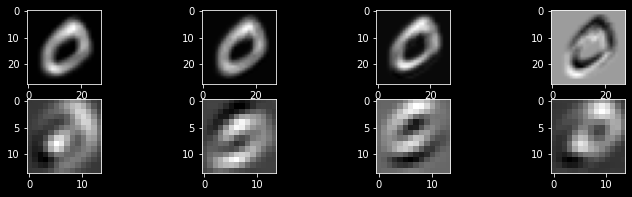

Epoch #5
training loss 0.40271759033203125
testing loss 0.4032641351222992
training accuracy 0.893
testing accuracy 0.87


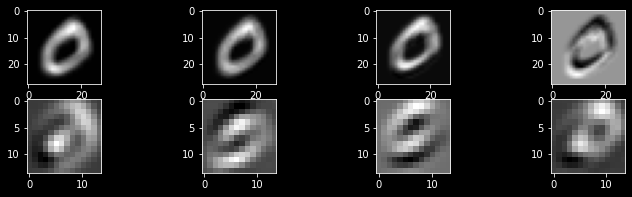

Epoch #6
training loss 0.35381463170051575
testing loss 0.32496392726898193
training accuracy 0.905
testing accuracy 0.93


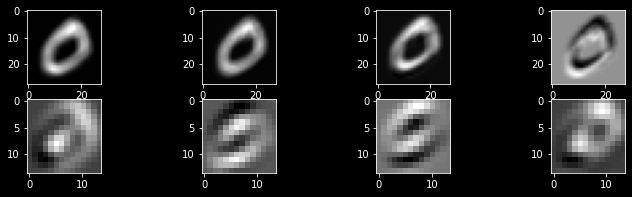

Epoch #7
training loss 0.4214368760585785
testing loss 0.47001492977142334
training accuracy 0.87
testing accuracy 0.78


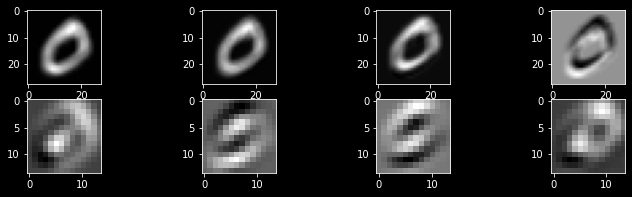

Epoch #8
training loss 0.2641823887825012
testing loss 0.23091235756874084
training accuracy 0.935
testing accuracy 0.93


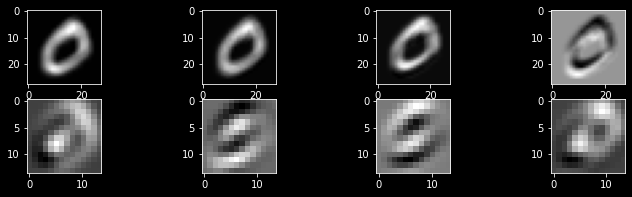

Epoch #9
training loss 0.2471095770597458
testing loss 0.2373262643814087
training accuracy 0.935
testing accuracy 0.93


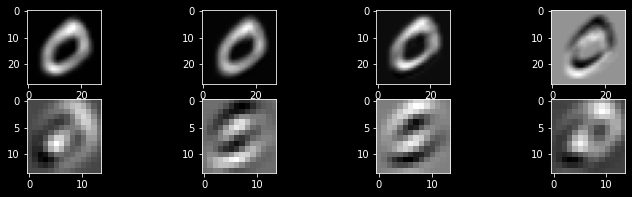

Epoch #10
training loss 0.18555326759815216
testing loss 0.13937467336654663
training accuracy 0.953
testing accuracy 0.97


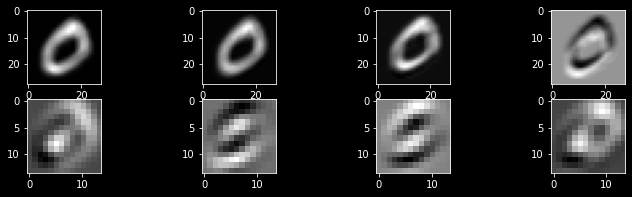

Epoch #11
training loss 0.19614827632904053
testing loss 0.1829172968864441
training accuracy 0.94
testing accuracy 0.93


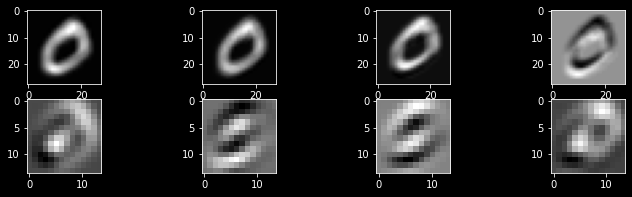

Epoch #12
training loss 0.17120982706546783
testing loss 0.15175369381904602
training accuracy 0.948
testing accuracy 0.96


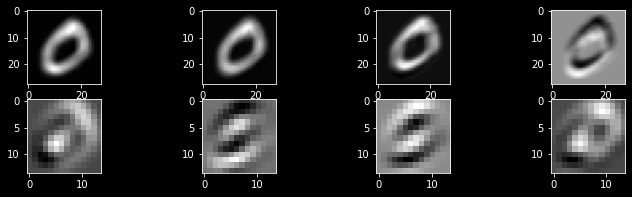

Epoch #13
training loss 0.1591659039258957
testing loss 0.14856722950935364
training accuracy 0.955
testing accuracy 0.93


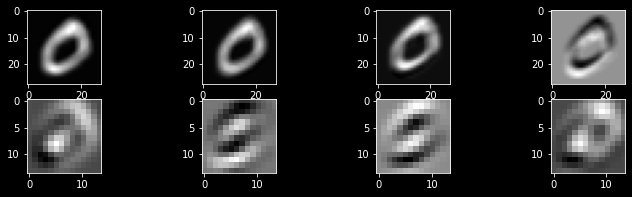

Epoch #14
training loss 0.1382727026939392
testing loss 0.14083042740821838
training accuracy 0.957
testing accuracy 0.97


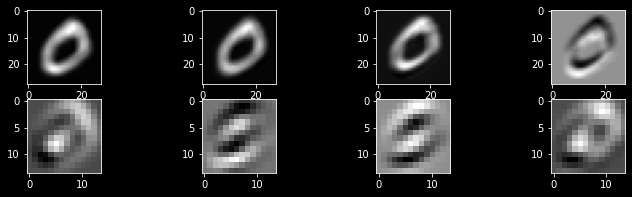

Epoch #15
training loss 0.1606357991695404
testing loss 0.17865785956382751
training accuracy 0.946
testing accuracy 0.93


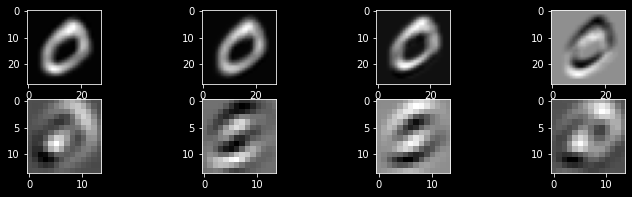

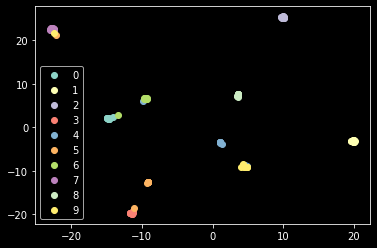

In [19]:
network = Network_dropout(0.5)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)

Epoch #1
training loss 2.2629733085632324
testing loss 2.2624146938323975
training accuracy 0.192
testing accuracy 0.2


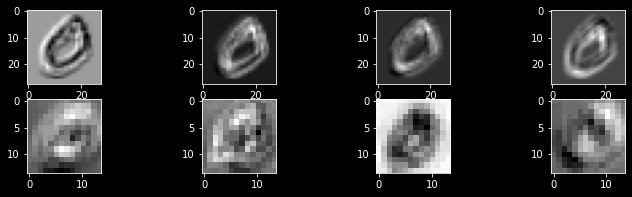

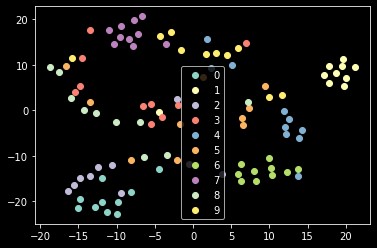

Epoch #2
training loss 1.1536173820495605
testing loss 1.2069319486618042
training accuracy 0.716
testing accuracy 0.71


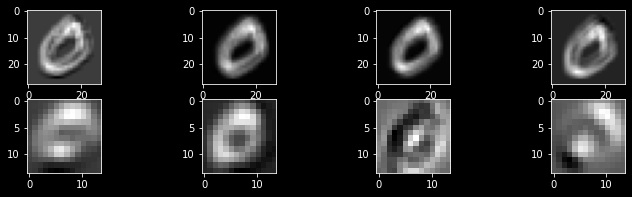

Epoch #3
training loss 0.6449304223060608
testing loss 0.6699972748756409
training accuracy 0.807
testing accuracy 0.77


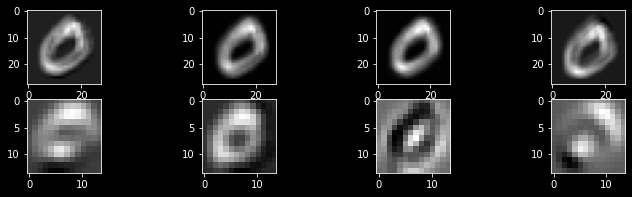

Epoch #4
training loss 0.49579986929893494
testing loss 0.5478386282920837
training accuracy 0.853
testing accuracy 0.81


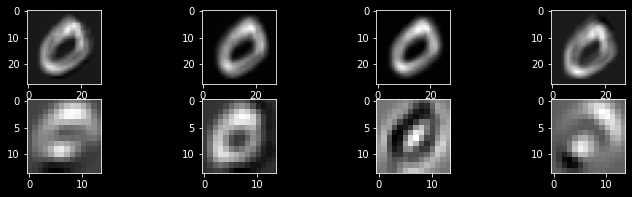

Epoch #5
training loss 0.46245744824409485
testing loss 0.4894605278968811
training accuracy 0.861
testing accuracy 0.87


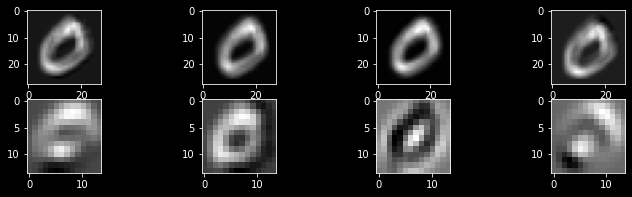

Epoch #6
training loss 0.38809606432914734
testing loss 0.42452239990234375
training accuracy 0.877
testing accuracy 0.84


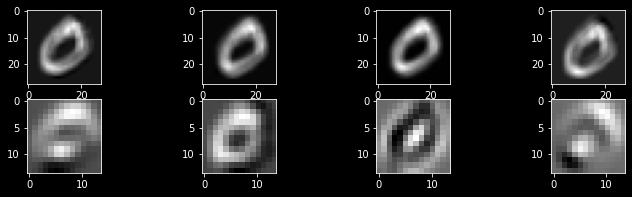

Epoch #7
training loss 0.31264528632164
testing loss 0.3013969957828522
training accuracy 0.91
testing accuracy 0.93


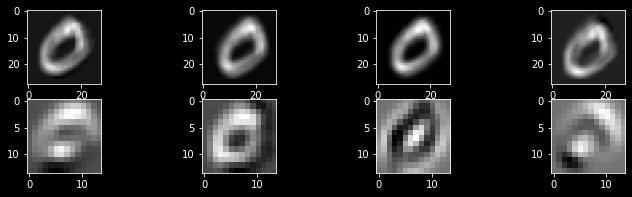

Epoch #8
training loss 0.29086729884147644
testing loss 0.3376976251602173
training accuracy 0.923
testing accuracy 0.86


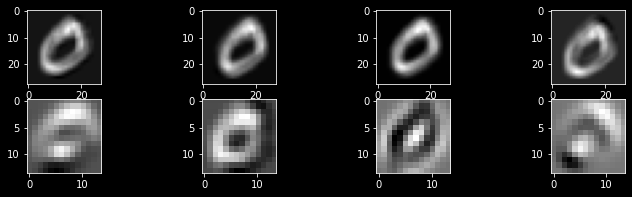

Epoch #9
training loss 0.2971682548522949
testing loss 0.27051711082458496
training accuracy 0.891
testing accuracy 0.9


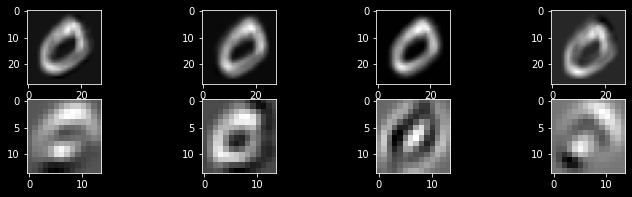

Epoch #10
training loss 0.22905117273330688
testing loss 0.25848111510276794
training accuracy 0.935
testing accuracy 0.89


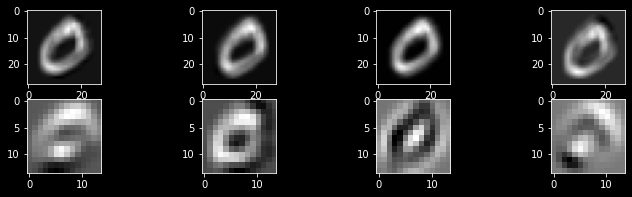

Epoch #11
training loss 0.2486269772052765
testing loss 0.29935532808303833
training accuracy 0.94
testing accuracy 0.92


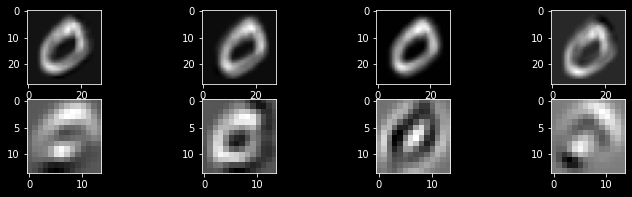

Epoch #12
training loss 0.21000829339027405
testing loss 0.2658626437187195
training accuracy 0.938
testing accuracy 0.89


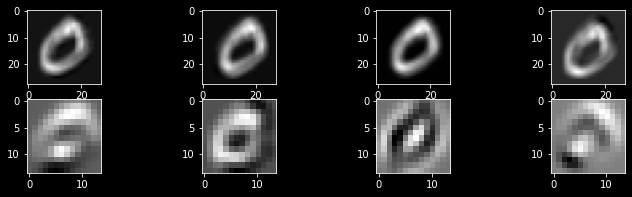

Epoch #13
training loss 0.18518993258476257
testing loss 0.21288558840751648
training accuracy 0.944
testing accuracy 0.92


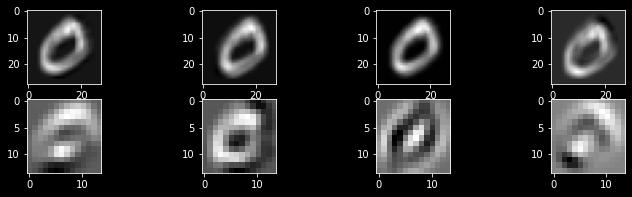

Epoch #14
training loss 0.1381155103445053
testing loss 0.1626262217760086
training accuracy 0.96
testing accuracy 0.94


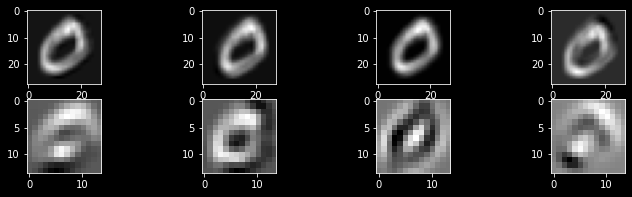

Epoch #15
training loss 0.15049102902412415
testing loss 0.1964549571275711
training accuracy 0.956
testing accuracy 0.92


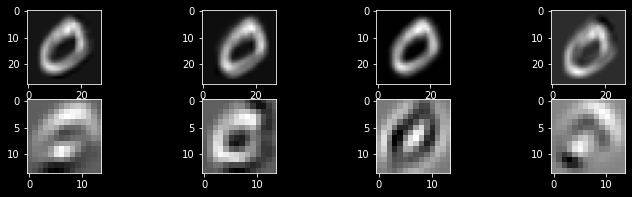

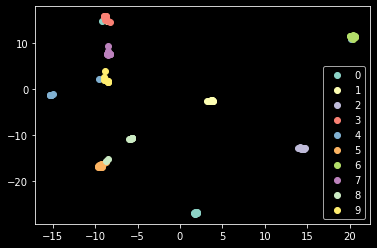

In [20]:
network = Network_dropout(0.8)
optimizer_rmsprop = optim.RMSprop(network.parameters(), lr = 0.001, alpha = 0.9, eps=1e-9)
train(network, x_train, y_train, 15, 15, optimizer_rmsprop)